In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from sklearn.cluster import SpectralClustering
import scipy
from scipy import signal
from prettytable import PrettyTable
from sklearn.metrics.pairwise import rbf_kernel
import scipy.io
from sklearn.neighbors import kneighbors_graph
import cv2
from sklearn.cluster import KMeans
import random as r
from scipy.stats import entropy
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,confusion_matrix,precision_recall_fscore_support



In [2]:
def getData(dirs):
  gt=[]
  Images3d = []
  dimensions = []
  shapegt = []
  for dir in tqdm(dirs):
    names = glob.glob(f'{dir}*')
    names.sort()

    image = [scipy.io.loadmat(name) for name in names if name.endswith('.mat')]
    for i in image:
      shapegt.append(np.array(i['groundTruth']).shape[1]) #number of ground truth pics
    gt.append(image)
    image = [np.float32(cv2.imread(name)) for name in names if name.endswith('.jpg')]
    Images3d.append(image)
    ind = 0;
    for i in image:
      dimensions.append(i.shape)
      image[ind] = image[ind].reshape((-1,3))
      ind += 1

  #gt = np.asarray(gt)
  Images3d = np.asarray(Images3d)
  dimensions = np.asarray(dimensions)
  shapegt = np.asarray(shapegt)
  


   
  return gt,Images3d,dimensions,shapegt

In [3]:
!unzip /content/dataset  -d "/content/data"
path ="/content/data/dataset/"
dirs = glob.glob(f'{path}*/')


Archive:  /content/dataset.zip
   creating: /content/data/dataset/
  inflating: /content/data/dataset/.DS_Store  
  inflating: /content/data/__MACOSX/dataset/._.DS_Store  
   creating: /content/data/dataset/test/
   creating: /content/data/dataset/train/
  inflating: /content/data/dataset/test/5096.jpg  
  inflating: /content/data/__MACOSX/dataset/test/._5096.jpg  
  inflating: /content/data/dataset/test/10081.jpg  
  inflating: /content/data/__MACOSX/dataset/test/._10081.jpg  
  inflating: /content/data/dataset/test/5096.mat  
  inflating: /content/data/__MACOSX/dataset/test/._5096.mat  
  inflating: /content/data/dataset/test/10081.mat  
  inflating: /content/data/__MACOSX/dataset/test/._10081.mat  
  inflating: /content/data/dataset/test/6046.jpg  
  inflating: /content/data/__MACOSX/dataset/test/._6046.jpg  
  inflating: /content/data/dataset/test/3063.jpg  
  inflating: /content/data/__MACOSX/dataset/test/._3063.jpg  
  inflating: /content/data/dataset/test/8068.jpg  
  inflating:

In [4]:
ground_truth, images, dimensions , groundTruthNumber = getData(dirs)

100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


In [10]:
testing = images[1]

testgt = ground_truth[1]
training = images[0]
traingt = ground_truth[0]

groundTruthNumber = groundTruthNumber.reshape(2,-1)


groundTruthNumber_train = groundTruthNumber[0]
groundTruthNumber_test = groundTruthNumber[1]


dimensions = dimensions.reshape(2,-1,3)
print(dimensions.shape)

training_dimensions = dimensions[0]
test_dimensions = dimensions[1]

gt_training_dimensions = np.delete(training_dimensions,2,1) 
gt_testing_dimensions = np.delete(test_dimensions,2,1) 








(2, 6, 3)


In [11]:
def get_groundTruth_dimensions(ground_truth,pic_number,groundTruthNumber):
  ground_truth_pics = []

  gt = ground_truth[pic_number]["groundTruth"]
  for i in range(groundTruthNumber):
    ground_truth_pics.append(gt[0][i]['Segmentation'][0][0])

  ground_truth_pics = np.asarray(ground_truth_pics)
  return ground_truth_pics

In [12]:
####ground truth pictures for first training picture

def get_groundTruth_pictures(dataset,picnumber):

  ground_truth_pics = get_groundTruth_dimensions(dataset,picnumber,groundTruthNumber_train[picnumber])

  print(ground_truth_pics.shape)

  ground_truth_pics = ground_truth_pics.reshape(groundTruthNumber_train[picnumber],-1)

  print(ground_truth_pics.shape)

  fig = plt.figure(figsize=(17,12))
  m = 1
  for i in range(len(ground_truth_pics)):
    ax= fig.add_subplot(2,3,m) 
    m += 1
  

    ax.imshow((ground_truth_pics[i]).reshape(gt_training_dimensions[picnumber]).astype('uint8'))
  return ground_truth_pics



In [8]:
K = [3,5,7,9,11]





def KMeans_Function(image,K,reshape_dimensions):
  i = 1
  fig = plt.figure(figsize=(17,12))
  images_label_different_k = []
  for k in K:
  
    image = np.float32(image)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()
    images_label_different_k.append(labels)

    segmented_image = centers[labels.flatten()]

    segmented_image = segmented_image.reshape(reshape_dimensions)
    # show the image
    ax= fig.add_subplot(2,3,i) 
    i += 1
    ax.imshow(segmented_image)

  images_label_different_k = np.asarray(images_label_different_k)
  return images_label_different_k

  

In [13]:
print((training[2].reshape(training_dimensions[2])).shape)

(321, 481, 3)


(6, 321, 481)
(6, 154401)


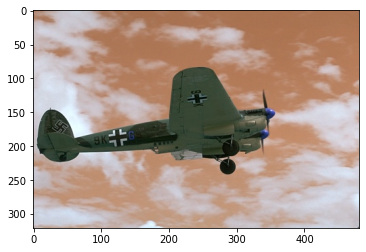

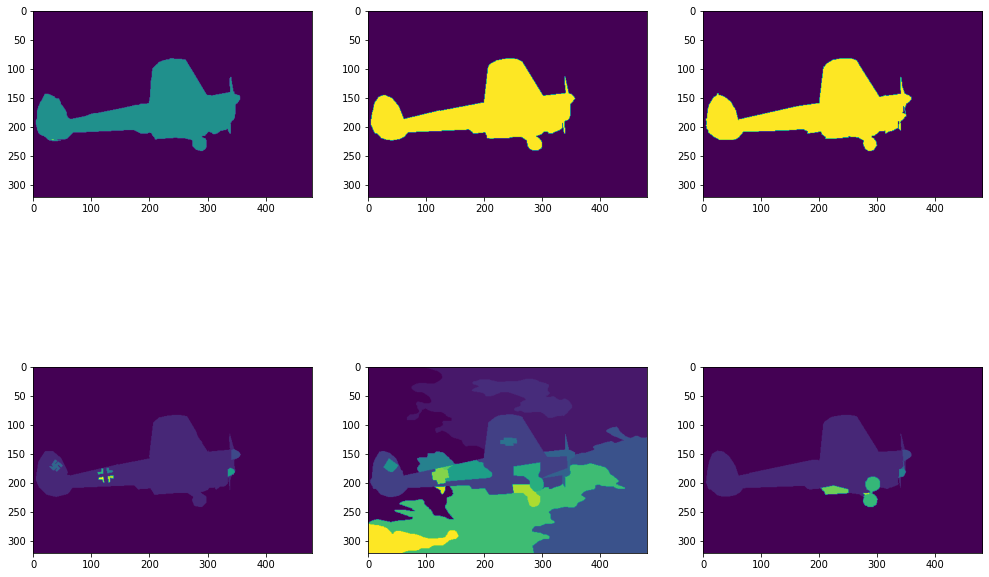

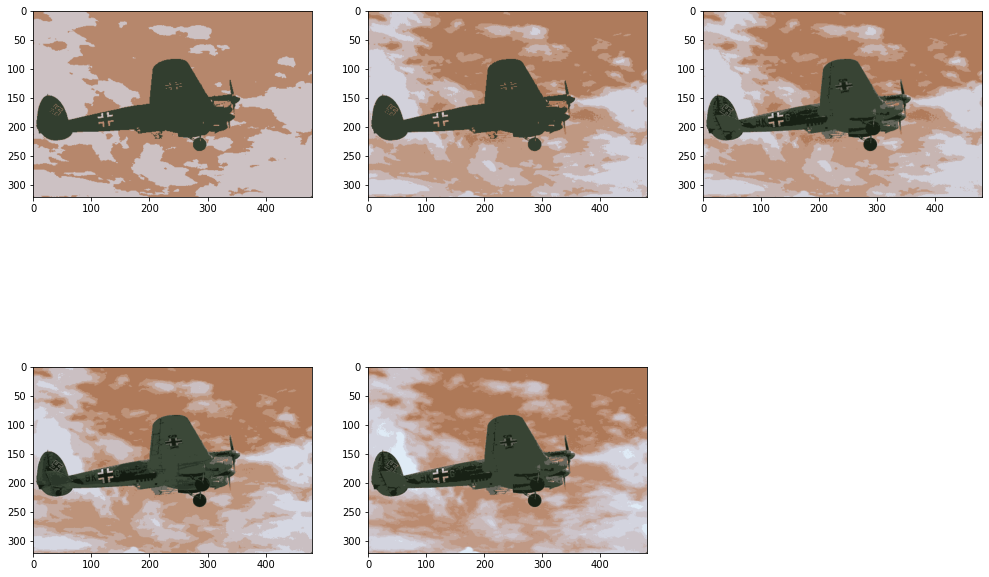

In [16]:
######## 3A ##########
plt.imshow(training[2].reshape(training_dimensions[2]).astype('uint8'))
gt_pics = get_groundTruth_pictures(traingt,2)




labels = KMeans_Function(training[2],K,training_dimensions[2])


In [23]:



def get_evaluation(ground_truth_pics,images_label_different_k):
  t = PrettyTable(['Ground Truth Image Number','K','Precision', 'Recall','FMeasure','Entropy'])
  
  for ground_pic_number in range(len(ground_truth_pics)):
    sum_entropy = 0
    sum_fmeasure = 0

    for i in range(images_label_different_k.shape[0]):
    
      cm = confusion_matrix(images_label_different_k[i], ground_truth_pics[ground_pic_number])
      r = precision_recall_fscore_support(images_label_different_k[i], ground_truth_pics[ground_pic_number],
      zero_division = 0) #recall , prescision, fmeasure

      
      sum_fmeasure += (r[2][0]+r[2][1])/2
      conditional_entropy = entropy(cm, base=2)
      sum = cm.sum()
      column_sums = cm.sum(axis=0)
      total_entropy = 0
      for p in range(len(conditional_entropy)):
        if(np.isnan(conditional_entropy[p])==False):

          total_entropy += conditional_entropy[p]*(column_sums[p]/sum)
      
      sum_entropy += total_entropy
      

      t.add_row([ ground_pic_number, 5 ,"{:.3f}".format(  (r[0][0]+r[0][1])/2 ) ,
                 "{:.3f}".format( (r[1][0]+r[1][1])/2 ) ,"{:.3f}".format(( (r[2][0]+r[2][1])/2 )) ,
                 "{:.3f}".format(total_entropy) ])
    print(t)
    t.clear_rows()
    print("Average Entropy for Pic Number ",ground_pic_number, "is ",sum_entropy/images_label_different_k.shape[0] )
    print("Average FMeasure for Pic Number ",ground_pic_number, "is ",sum_fmeasure/images_label_different_k.shape[0] )




    


In [20]:
####### 3B ##########

get_evaluation(gt_pics,labels)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


+---------------------------+----+-----------+--------+----------+---------+
| Ground Truth Image Number | K  | Precision | Recall | FMeasure | Entropy |
+---------------------------+----+-----------+--------+----------+---------+
|             0             | 3  |   0.225   | 0.497  |  0.309   |  0.916  |
|             0             | 5  |   0.000   | 0.002  |  0.001   |  1.764  |
|             0             | 7  |   0.099   | 0.498  |  0.165   |  1.912  |
|             0             | 9  |   0.087   | 0.495  |  0.148   |  2.230  |
|             0             | 11 |   0.000   | 0.002  |  0.000   |  2.628  |
+---------------------------+----+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.8903844672960708
Average FMeasure for Pic Number  0 is  0.12454045705089425
+---------------------------+----+-----------+--------+----------+---------+
| Ground Truth Image Number | K  | Precision | Recall | FMeasure | Entropy |
+---------------------------+----+---

In [21]:
############### BONUS ############


def Bonus_Encoding(image,dimensions):
  import random 

  picture = image.reshape(dimensions)

  features=[]
  for i in range(321):
    for j in range(481):
      r=picture[i][j][0]
      g=picture[i][j][1]
      b=picture[i][j][2]
      result= [i,j,r,g,b]
      features.append(result)   
  features = np.array(features)

  new_pictures = []


  image_sample = features

  images_label_different_k = []
  for cluster_number in range(5,7,2): 

    cluster_colours_pics = np.zeros(image.shape,dtype=np.uint8) 
    random_cluster_colors = []
  
    model = KMeans(n_clusters= cluster_number, random_state=0).fit(image_sample)
    print(cluster_number)
    images_label_different_k.append(model.labels_)
     
  
    for i in range(cluster_number): ##random colour for each cluster
      random_cluster_colors.append(np.array([random.randint(0, 255),random.randint(0, 255),random.randint(0, 255)]))

    for i in range(image_sample.shape[0]):
      cluster_colours_pics[i] = random_cluster_colors[model.labels_[i]] ## assigning each pixel to a clusters
     
    new_pictures.append(cluster_colours_pics)

  fig = plt.figure(figsize=(17,12))
  m = 1
  for i in range(len(new_pictures)):
    ax= fig.add_subplot(2,3,m) 
    m += 1
  

    plt.imshow(new_pictures[i].reshape(dimensions));
    images_label_different_k = np.asarray(images_label_different_k)

  return images_label_different_k







5


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             0             | 5 |   0.125   | 0.496  |  0.200   |  1.774  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.7741812477994068
Average FMeasure for Pic Number  0 is  0.19987869059361962
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             1             | 5 |   0.125   | 0.497  |  0.200   |  1.772  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  1 is  1.771792271186077
Average FMeasure for Pic Number  1 is  0.20031254787804506
+--------

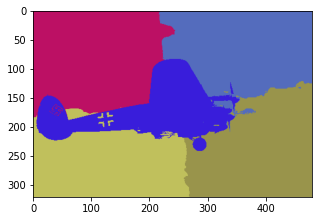

In [24]:

#random_cluster_colors = np.array([r.randint(0, 255),r.randint(0, 255),r.randint(0, 255)])


labels_bonus = Bonus_Encoding(training[2],training_dimensions[2])

get_evaluation( gt_pics , labels_bonus )












In [ ]:
print(labels_bonus.shape[0])

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(321, 481, 3)
(154401, 3)
(154401, 4)


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             0             | 5 |   0.000   | 0.002  |  0.000   |  1.341  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.341444833047802
Average FMeasure for Pic Number  0 is  0.0001252865007480341
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             1             | 5 |   0.000   | 0.001  |  0.000   |  1.338  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  1 is  1.3382486419640987
Average FMeasure for Pic Number  1 is  5.160529322864831e-05
+----

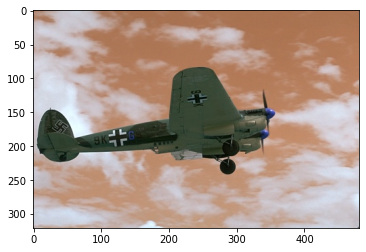

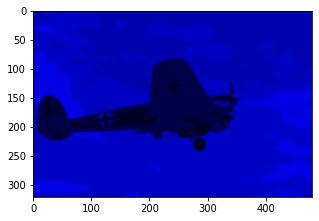

In [25]:
###### BONUS TRY 2 3SHAN NO SODA3 #############

import PIL.Image
from matplotlib import cm
import matplotlib.colors as mcolors


rgb_image = training[2].reshape(training_dimensions[2])
print(rgb_image.shape)


rgb_image = rgb_image.astype(np.uint8)
im = Image.fromarray(rgb_image)

hsv = mcolors.rgb_to_hsv(im)
plt.imshow(hsv)
new_colour_image = np.array(hsv)
new_colour_image = new_colour_image.reshape(-1,3)
print(new_colour_image.shape)

rgba_pic = im.convert('RGBA')
plt.imshow(rgba_pic)
new_colour_image_a = np.array(rgba_pic)
new_colour_image_a = new_colour_image_a.reshape(-1,4)
print(new_colour_image_a.shape)




bonus_two = KMeans_Function(new_colour_image,[5],training_dimensions[2])
get_evaluation( gt_pics , bonus_two ) ##HSV











/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             0             | 5 |   0.000   | 0.001  |  0.000   |  1.536  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.5360889062655956
Average FMeasure for Pic Number  0 is  0.00011051189107948015
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             1             | 5 |   0.000   | 0.001  |  0.000   |  1.534  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  1 is  1.5337967317657382
Average FMeasure for Pic Number  1 is  5.895878780732268e-05
+--

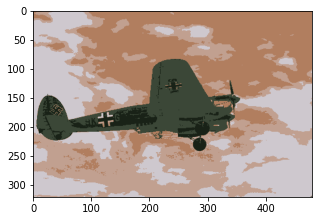

In [27]:
bonus_two_2 = KMeans_Function(new_colour_image_a,[5],(321,481,4))
get_evaluation( gt_pics , bonus_two_2 )

In [ ]:
print(bonus_two.shape)
print(labels.shape)

(1, 154401)
(1, 154401)


In [26]:


def Spectral_Clustering_5NN(picnumber):
  labels = []
  
  fig = plt.figure(figsize=(17,12))


  rgb_image = training[picnumber].reshape(training_dimensions[picnumber])
  print(rgb_image.shape)


  rgb_image = rgb_image.astype(np.uint8)
  im = Image.fromarray(rgb_image)


  width, height = im.size 
  
  # Setting the points for cropped image 
  left = 4
  top = height / 5
  right = 154
  bottom = 3 * height / 5
  
  # Cropped image of above dimension 
  # (It will not change orginal image) 
  im1 = im.crop((left, top, right, bottom))
  newsize = (100, 100)
  im1 = im1.resize(newsize)
  # Shows the image in image viewer 
  im1.show() 
  plt.imshow(im1)


  im1_array = np.array(im1)
  im1_array = im1_array.reshape(-1,3)
  print(im1_array.shape)



  affinity_matrix = rbf_kernel(im1_array,gamma = 0.01)
  affinity_matrix=np.array(affinity_matrix)



  Spectral_Clusters = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity="precomputed").fit(affinity_matrix)



  Spectral_segmented_image = []
  colors = [[255,0,255],[255,153,204],[51,51,51],[0,0,0],[128,0,0]]


  for i in range(affinity_matrix.shape[0]):
    Spectral_segmented_image.append(colors[Spectral_Clusters.labels_[i]])
  labels.append(Spectral_Clusters.labels_)

  labels = np.asarray(labels)
  
  Spectral_segmented_image=np.array(Spectral_segmented_image).reshape(100,100,3)
  ax= fig.add_subplot(2,1,1) 
  
  ax.imshow(Spectral_segmented_image)
  return Spectral_segmented_image,labels
  

(5, 321, 481)
(5, 154401)
(5, 481, 321)
(5, 154401)
(6, 321, 481)
(6, 154401)
(5, 321, 481)
(5, 154401)
(5, 481, 321)
(5, 154401)


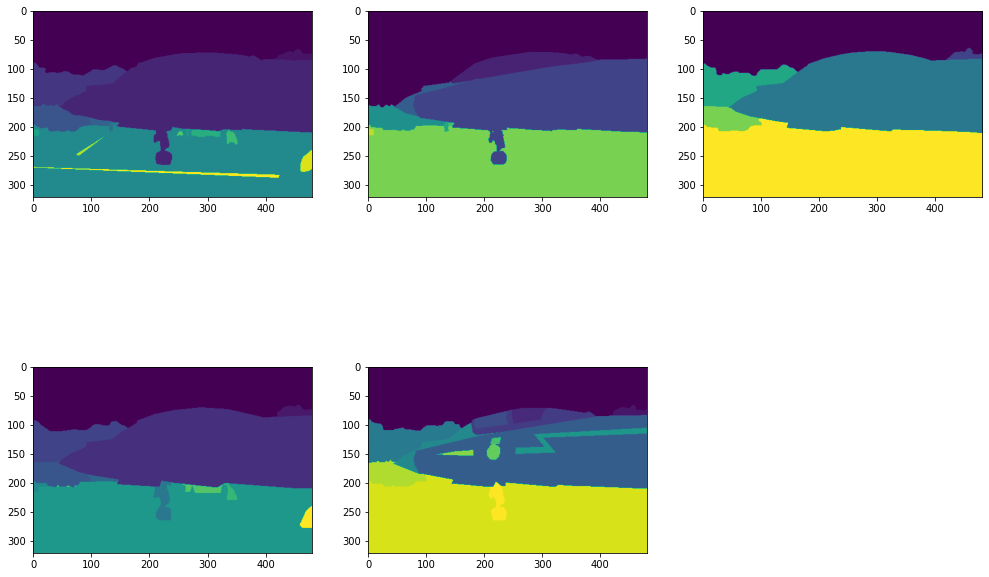

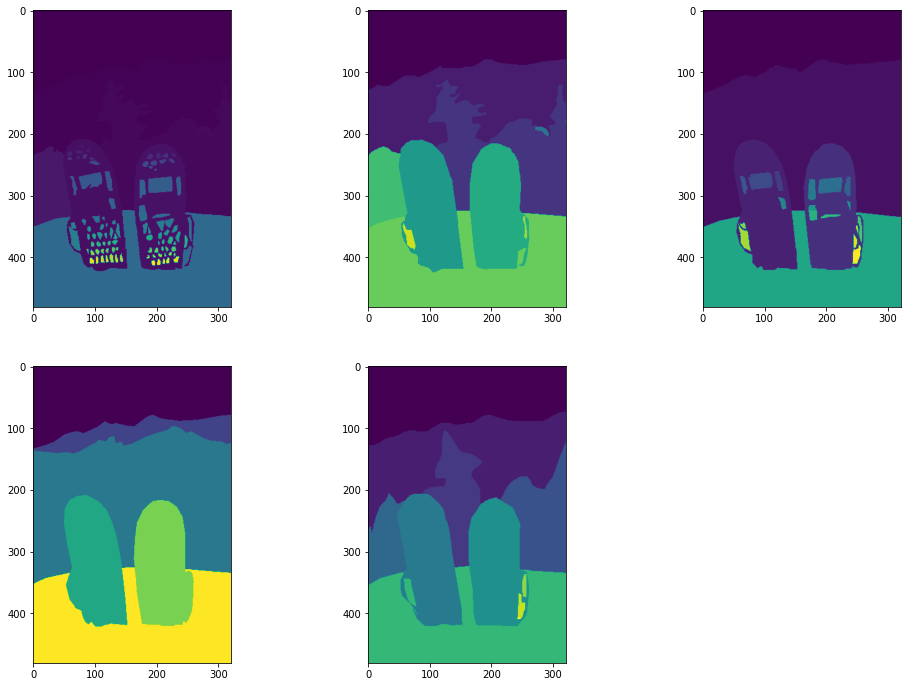

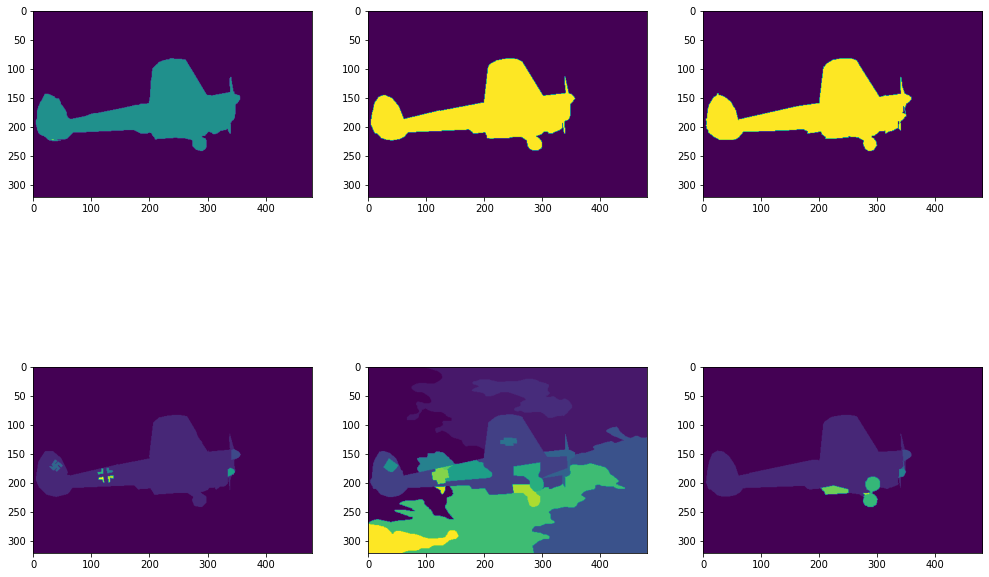

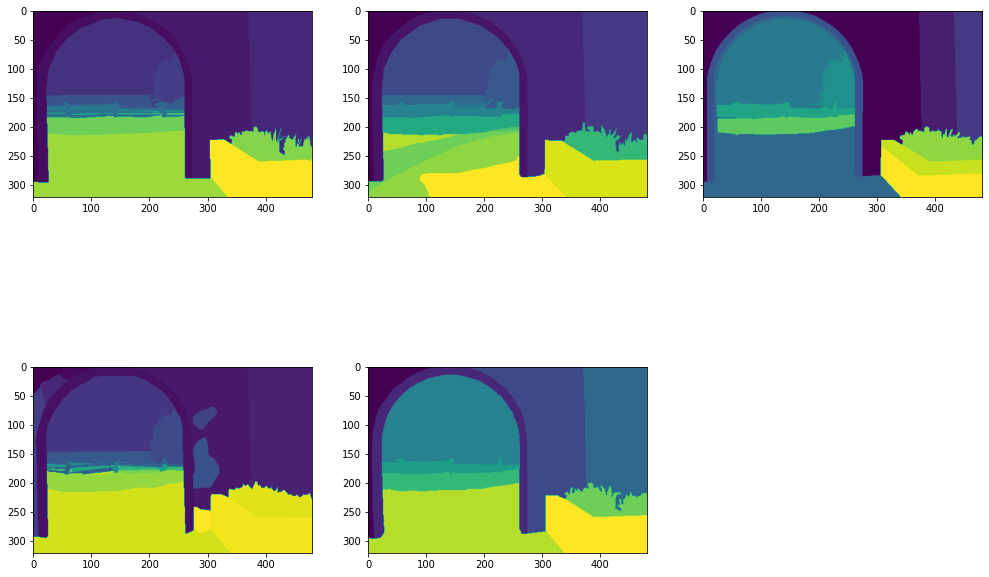

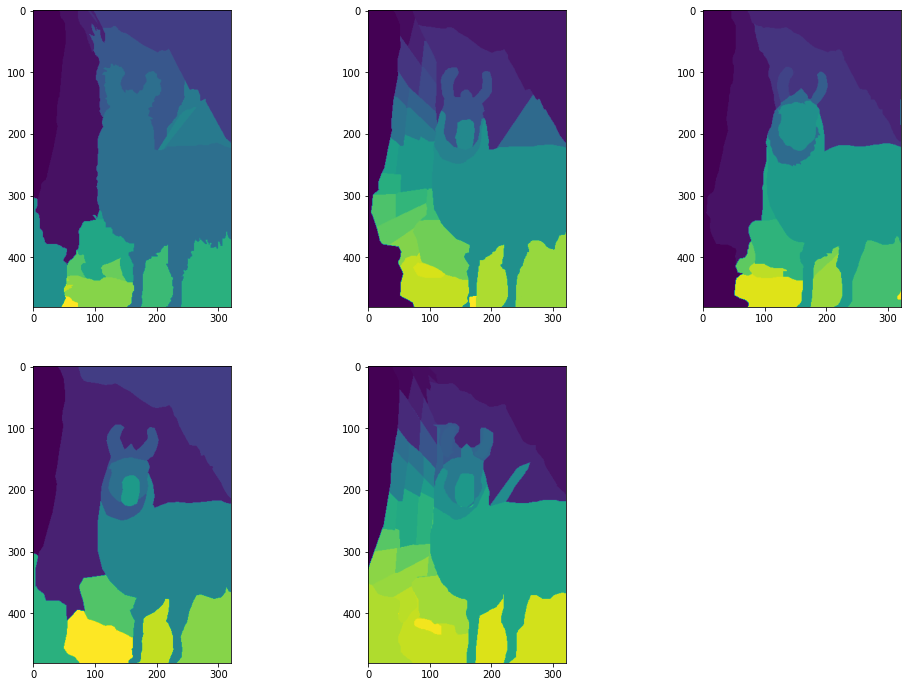

In [29]:
for i in range(5):
  gt_pics = get_groundTruth_pictures(traingt,i)

In [30]:

def cropPhoto(picnumber):

  plt.imshow(training[2].reshape(training_dimensions[2]).astype('uint8'))
  gt_pics = get_groundTruth_pictures(traingt,2)

  rgb_image_actual = training[2].reshape(training_dimensions[2])
  print(rgb_image_actual.shape)


  rgb_image_actual = rgb_image_actual.astype(np.uint8)
  im_actual = Image.fromarray(rgb_image_actual)


  width, height = im_actual.size 
  
    # Setting the points for cropped image 
  left = 4
  top = height / 5
  right = 154
  bottom = 3 * height / 5
  
  # Cropped image of above dimension 
  # (It will not change orginal image) 
  im1_actual = im_actual.crop((left, top, right, bottom))
  newsize = (100, 100)
  im1_actual = im1_actual.resize(newsize)
  # Shows the image in image viewer 
  im1_actual.show() 
  plt.imshow(im1_actual)


  im1_array_actual = np.array(im1_actual)
  im1_array_actual = im1_array_actual.reshape(-1,3)
  print(im1_array_actual.shape)



  cropped_gt_pics = []
  print(gt_pics[0].shape)

  for m in range(len(gt_pics)):


    rgb_image = (gt_pics[m]).reshape(gt_training_dimensions[m]).astype('uint8')
    print(rgb_image.shape)


    rgb_image = rgb_image.astype(np.uint8)

    im = Image.fromarray(rgb_image)


    width, height = im.size 
  
    # Setting the points for cropped image 
    left = 4
    top = height / 5
    right = 154
    bottom = 3 * height / 5
  
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((left, top, right, bottom))
    newsize = (100, 100)
    im1 = im1.resize(newsize)
    # Shows the image in image viewer 
    im1.show() 
    plt.imshow(im1)


    im1_array = np.array(im1)
    #im1_array = im1_array.reshape(-1,3)
    cropped_gt_pics.append(im1_array)
  
    print(im1_array.shape)

  cropped_gt_pics = np.asarray(cropped_gt_pics)
  print("HELLO",cropped_gt_pics.shape)
  cropped_gt_pics = cropped_gt_pics.reshape(6,-1)

  return im1_array_actual, cropped_gt_pics










(6, 321, 481)
(6, 154401)
(321, 481, 3)
(10000, 3)
(154401,)
(321, 481)
(100, 100)
(481, 321)
(100, 100)
(321, 481)
(100, 100)
(321, 481)
(100, 100)
(481, 321)
(100, 100)
(321, 481)
(100, 100)
HELLO (6, 100, 100)
		 Evaluation between photo and KMeans Segmentation


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             0             | 5 |   0.000   | 0.001  |  0.000   |  1.747  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.746753968056069
Average FMeasure for Pic Number  0 is  0.0003050640634533252
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             1             | 5 |   0.038   | 0.193  |  0.064   |  2.151  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  1 is  2.1507629971965643
Average FMeasure for Pic Number  1 is  0.06355932203389832
+------

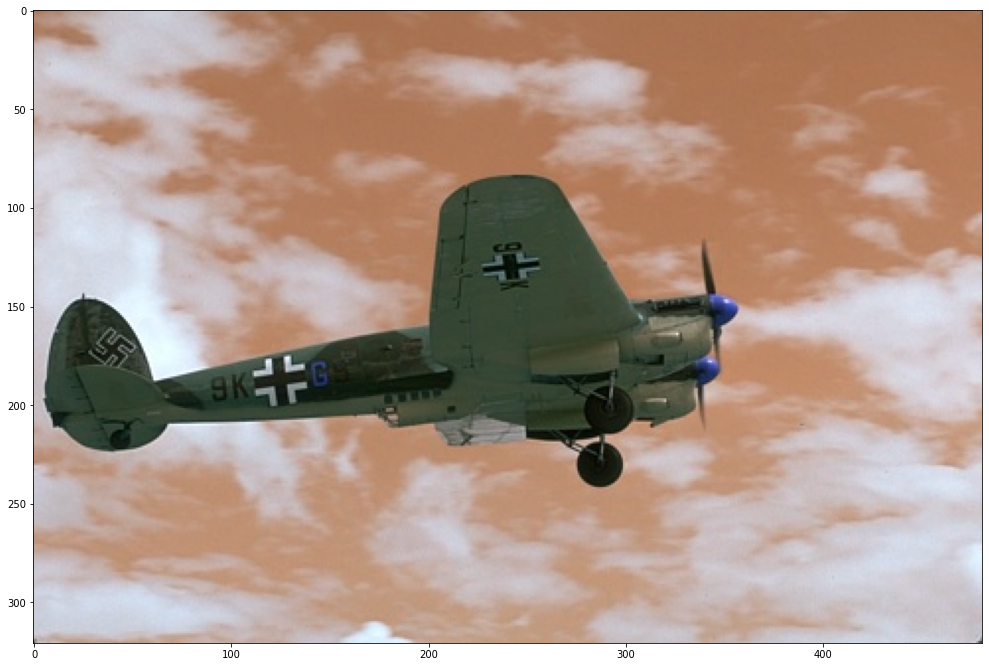

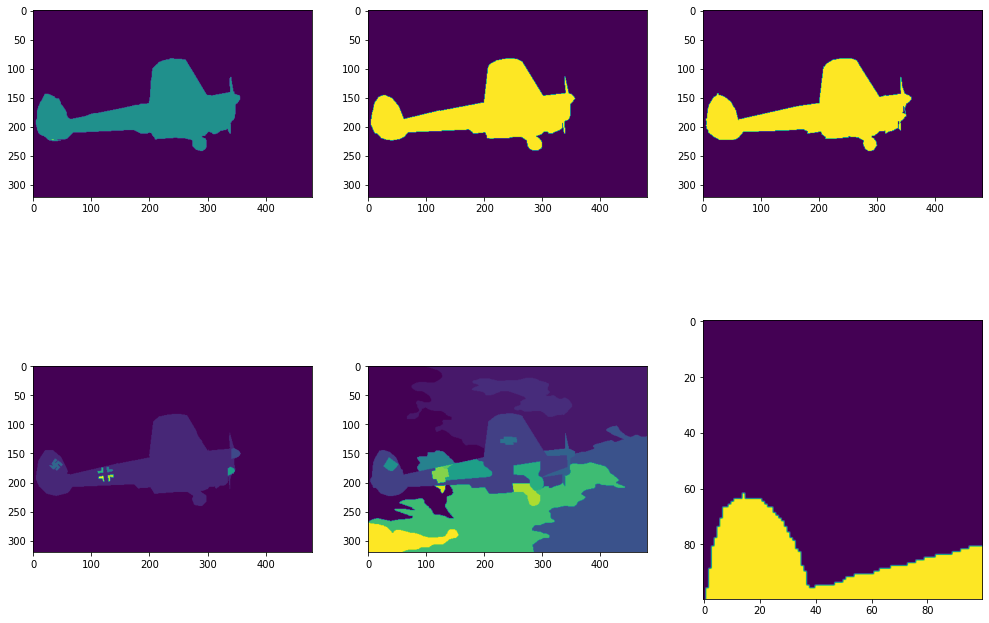

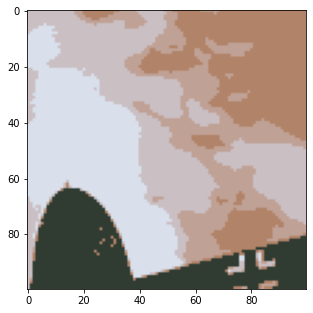

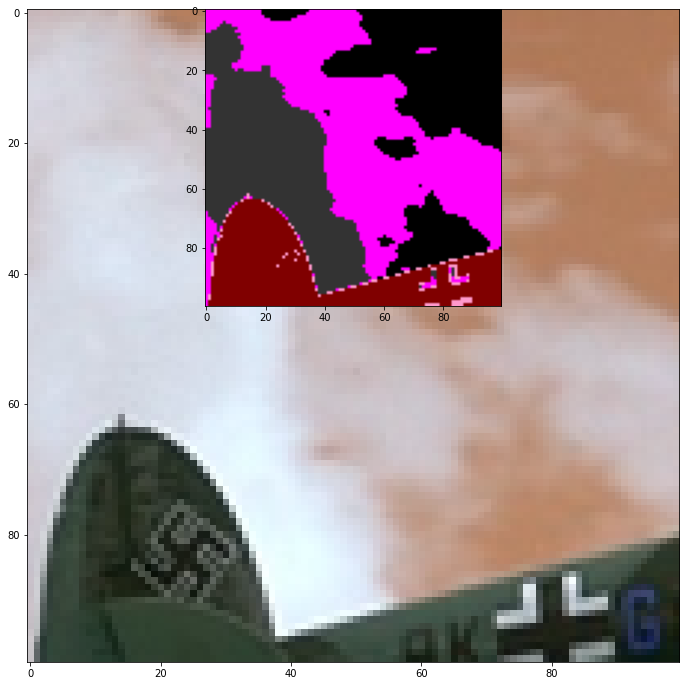

In [31]:
fig = plt.figure(figsize=(17,12))

im1_array_actual, cropped_gt_pics = cropPhoto(2)


print("\t\t Evaluation between photo and KMeans Segmentation")
labels_final = KMeans_Function(im1_array_actual,[5],(100,100,3))
get_evaluation( cropped_gt_pics , labels_final )



(321, 481, 3)
(10000, 3)
		 Evaluation between photo and Spectral Clustering Segmentation
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             0             | 5 |   0.140   | 0.495  |  0.218   |  1.409  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  0 is  1.409194175989278
Average FMeasure for Pic Number  0 is  0.2184929564148624
+---------------------------+---+-----------+--------+----------+---------+
| Ground Truth Image Number | K | Precision | Recall | FMeasure | Entropy |
+---------------------------+---+-----------+--------+----------+---------+
|             1             | 5 |   0.128   | 0.443  |  0.199   |  1.869  |
+---------------------------+---+-----------+--------+----------+---------+
Average Entropy for Pic Number  1 is

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


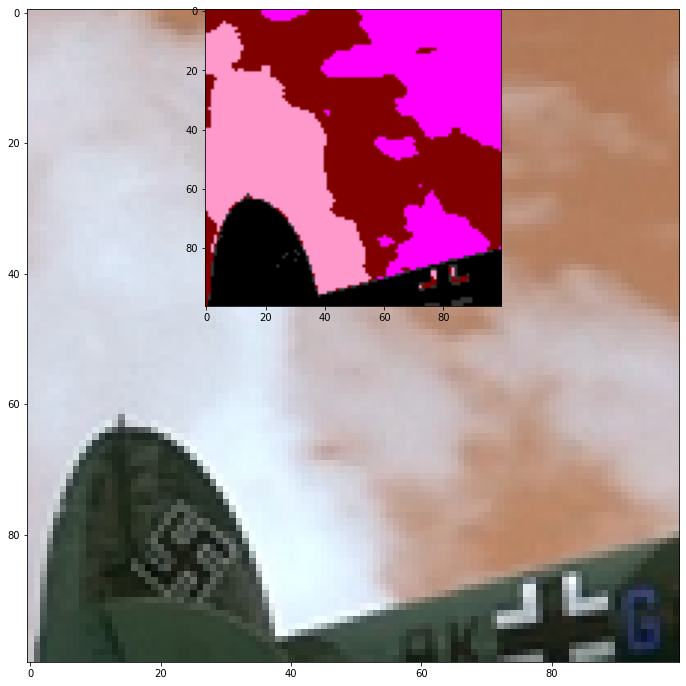

In [32]:

segmented_image, segmented_labels = Spectral_Clustering_5NN(2)
#segmented_image1,segmented_labels = segmented_image.reshape(-1,3)
print("\t\t Evaluation between photo and Spectral Clustering Segmentation")
get_evaluation( cropped_gt_pics , segmented_labels )